In [1]:
import scipy.io
import cv2
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil

In [2]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    # if len(img_1.shape) == 3 or len(img_2.shape) == 3:
    #     img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
    #     img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

In [3]:
train_images = []
train_annotations = []
train_folder = "Train"

for filename in os.listdir(train_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_folder, filename)
        train_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_folder, filename)
        train_annotations.append(image_path)

print("Number of images: ", len(train_images))
print("Number of annotations: ", len(train_annotations))

Number of images:  1201
Number of annotations:  1201


In [4]:
def visualize_annotations(image_path, annotation_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for matplotlib

    # Load annotations
    mat = scipy.io.loadmat(annotation_path)
    points = mat["annPoints"]

    # Plot image and points
    plt.imshow(image)
    if points.shape[1] == 2:
        plt.scatter(points[:, 0], points[:, 1], color='red', s=5)
    plt.show()

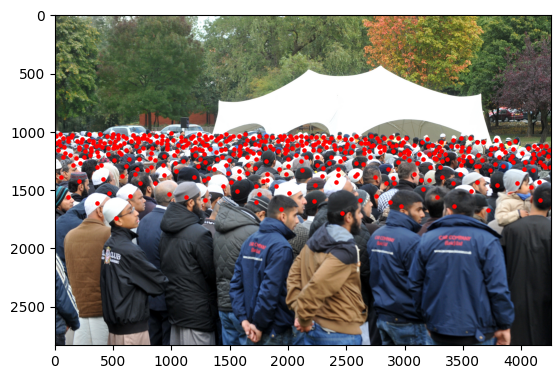

In [5]:
visualize_annotations(train_images[0], train_annotations[0])

In [12]:
def add_noise(image, noise_type="gaussian"):
    """Adds noise to an image."""
    # if noise_type == "gaussian":
    #     mean, stddev = 0, 1  # Mean and standard deviation for Gaussian noise
    #     noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    #     noisy_image = cv2.add(image, noise)  # Add noise to image
    
    if noise_type == "salt_pepper":
        prob = 0.005  # Probability of noise
        noisy_image = np.copy(image)
        black = 0
        white = 255
        
        # Apply salt & pepper noise
        num_pixels = int(prob * image.size)
        for _ in range(num_pixels // 2):
            x, y = random.randint(0, image.shape[1] - 1), random.randint(0, image.shape[0] - 1)
            noisy_image[y, x] = black
            x, y = random.randint(0, image.shape[1] - 1), random.randint(0, image.shape[0] - 1)
            noisy_image[y, x] = white

    elif noise_type == "poisson":
        noisy_image = np.random.poisson(image.astype(np.float32) * 0.5)  # Poisson noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    else:
        noisy_image = image  # No noise if invalid type
    
    return noisy_image


def generate_random_crops(image_path, annotation_path, save_dir, crop_size=(1024, 1024), num_crops=4, train=True, seed=42):
    random.seed(seed)
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    mat = scipy.io.loadmat(annotation_path)
    points = mat["annPoints"] 
    
    os.makedirs(save_dir, exist_ok=True)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    # If image is smaller than target size, pad it
    if h < crop_size[1] or w < crop_size[0]:
        pad_h = max(0, crop_size[1] - h)
        pad_w = max(0, crop_size[0] - w)
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        points = np.array([[x, y] for x, y in points])  # No need to adjust points, as padding doesn't shift them
        h, w, _ = image.shape
    
    for i in range(num_crops):
        cropped_points = []

        count = 0
        while len(cropped_points) <= 4:
            if count > 20:
                print(f"Skipping image {image_name}...")
                break
            crop_x = random.randint(0, w - crop_size[0])
            crop_y = random.randint(0, h - crop_size[1])
            
            cropped_image = image[crop_y:crop_y + crop_size[1], crop_x:crop_x + crop_size[0]]
            
            # Keep only annotations inside the cropped region
            cropped_points = np.array([[x - crop_x, y - crop_y] for x, y in points 
                                    if crop_x <= x < crop_x + crop_size[0] and crop_y <= y < crop_y + crop_size[1]])
            count += 1

        
        if train:
            if random.random() < 0.5:
                noise_type = random.choice(["salt_pepper", "poisson"])
                cropped_image = add_noise(cropped_image, noise_type)
        
        # Save cropped image
        crop_image_path = os.path.join(save_dir, f"{image_name}_crop_{i}.jpg")
        save_resized_image_and_annotations(cropped_image, cropped_points, crop_image_path, crop_image_path.replace(".jpg", ".mat"))


def save_resized_image_and_annotations(resized_image, resized_points, save_path_image, save_path_annotation):
    # Save resized image
    cv2.imwrite(save_path_image, resized_image)

    # Save resized annotations in .mat format
    annotation_dict = {"annPoints": resized_points}  # Store points in dictionary
    scipy.io.savemat(save_path_annotation, annotation_dict)


# Resize all images and annotations

target_size = (224, 224)

for image_path, annotation_path in zip(train_images, train_annotations):
    generate_random_crops(image_path, annotation_path, "Train_resized_2", crop_size=target_size, num_crops=4)


Skipping image img_0003...
Skipping image img_0003...
Skipping image img_0004...
Skipping image img_0004...
Skipping image img_0004...
Skipping image img_0010...
Skipping image img_0010...
Skipping image img_0010...
Skipping image img_0010...
Skipping image img_0011...
Skipping image img_0012...
Skipping image img_0012...
Skipping image img_0012...
Skipping image img_0014...
Skipping image img_0014...
Skipping image img_0016...
Skipping image img_0020...
Skipping image img_0023...
Skipping image img_0024...
Skipping image img_0029...
Skipping image img_0029...
Skipping image img_0029...
Skipping image img_0029...
Skipping image img_0030...
Skipping image img_0030...
Skipping image img_0039...
Skipping image img_0039...
Skipping image img_0039...
Skipping image img_0040...
Skipping image img_0040...
Skipping image img_0042...
Skipping image img_0042...
Skipping image img_0042...
Skipping image img_0043...
Skipping image img_0043...
Skipping image img_0043...
Skipping image img_0044...
S

In [13]:
train_resized_images = []
train_resized_annotations = []
train_resized_folder = "Train_resized_2"

for filename in os.listdir(train_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_annotations.append(image_path)

print("Number of images: ", len(train_resized_images))
print("Number of annotations: ", len(train_resized_annotations))

Number of images:  4804
Number of annotations:  4804


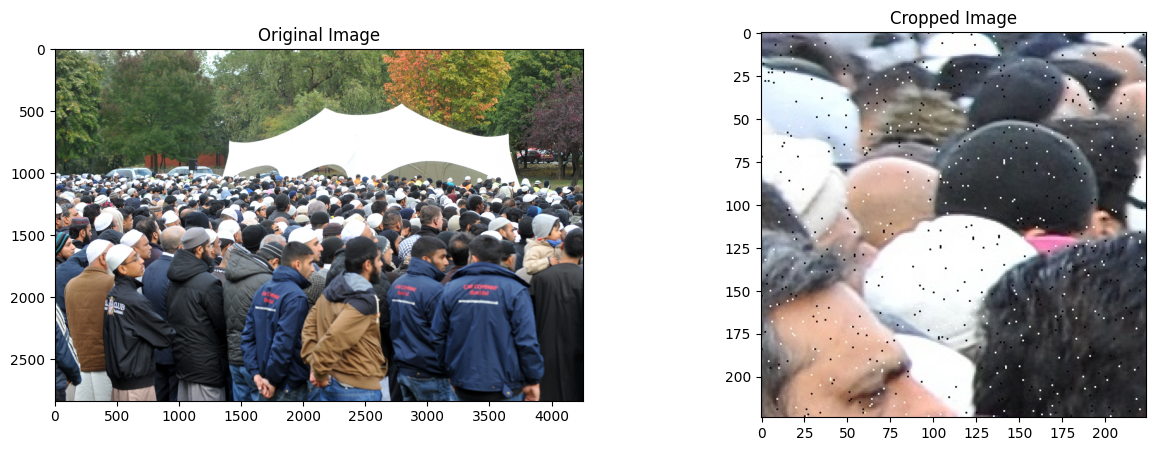

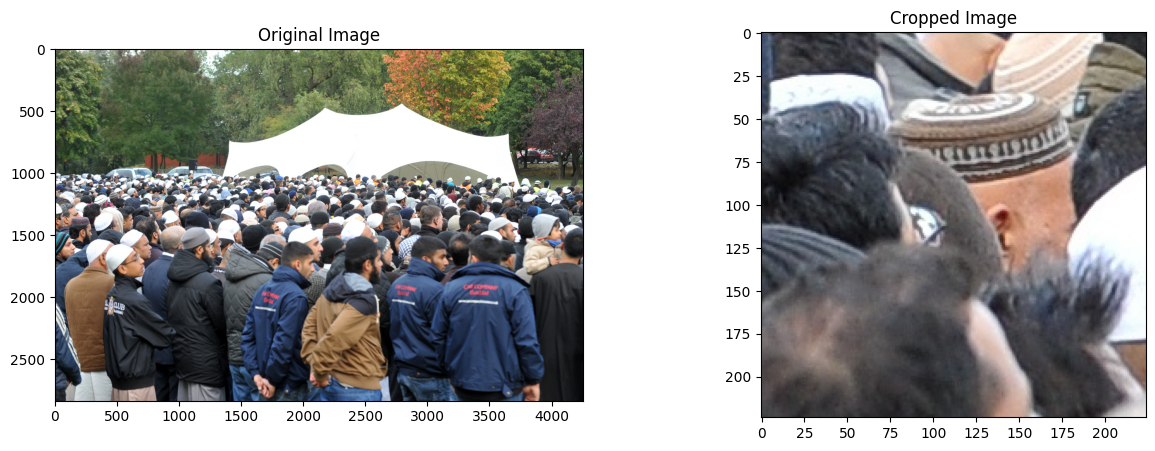

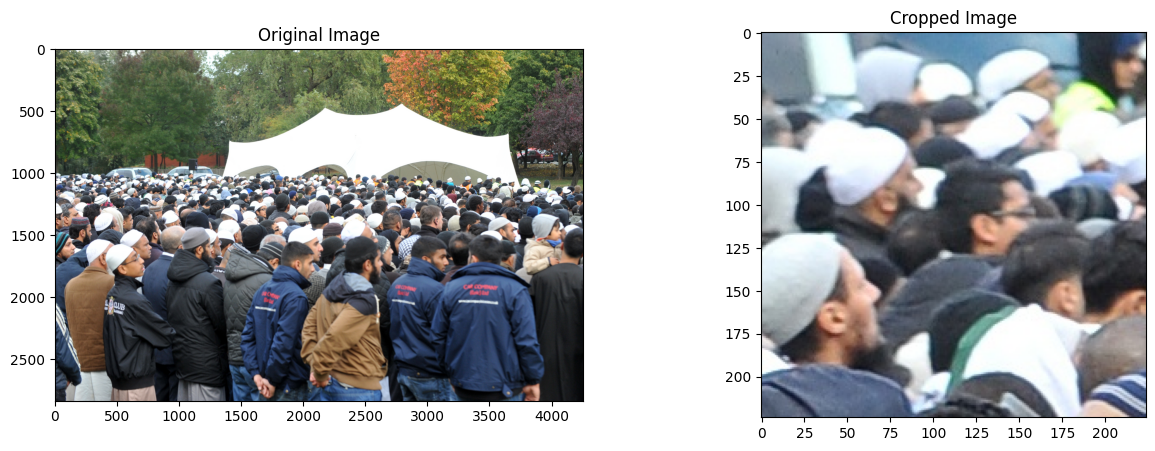

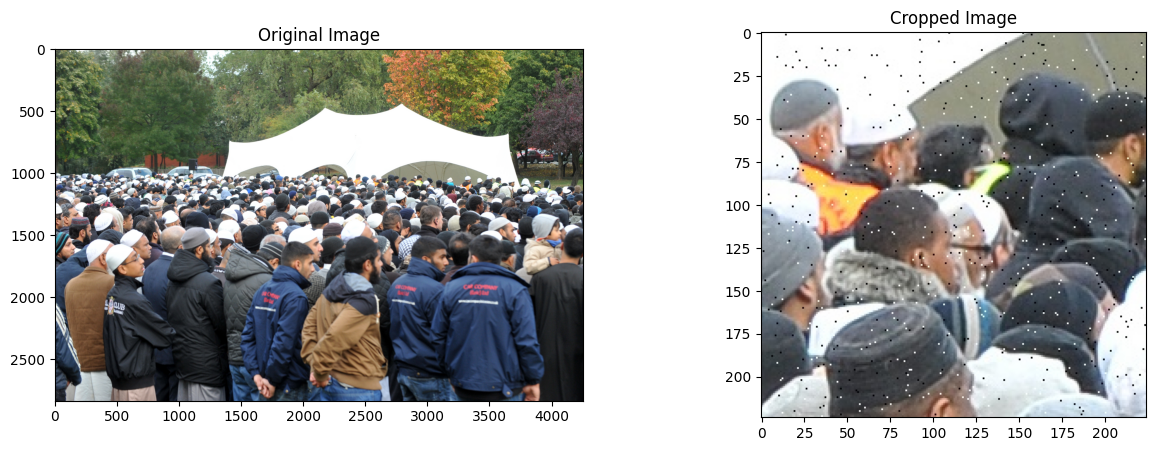

In [14]:
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[0]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[1]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[2]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")
plot_side_by_side(cv2.cvtColor(cv2.imread(train_images[0]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(train_resized_images[3]), cv2.COLOR_BGR2RGB), title1="Original Image", title2="Cropped Image")

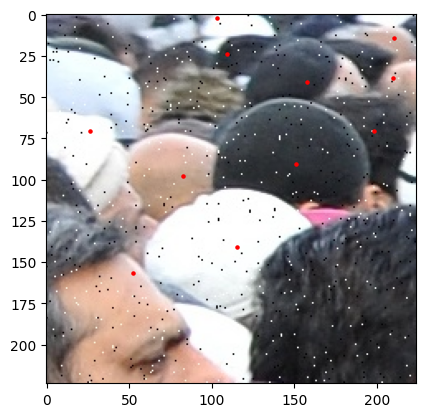

In [15]:
visualize_annotations(train_resized_images[0], train_resized_annotations[0])

Now we need to apply random croppping to Test and Validation sets

We need to split test set to both validation and test parts

In [70]:
def split_test_set(test_dir, val_dir, final_test_dir, split_ratio=0.5, seed=42):
    random.seed(seed)

    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(final_test_dir, exist_ok=True)

    all_images = [f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]
    random.shuffle(all_images)

    split_point = int(len(all_images) * split_ratio)
    val_images = all_images[:split_point]
    test_images = all_images[split_point:]

    def move_files(image_list, dest_dir):
        for img in image_list:
            img_path = os.path.join(test_dir, img)
            mat_path = os.path.join(test_dir, img.replace('.jpg', '_ann.mat').replace('.png', '_ann.mat'))  # Annotation file
            
            shutil.move(img_path, os.path.join(dest_dir, img))  # Move image
            shutil.move(mat_path, os.path.join(dest_dir, os.path.basename(mat_path)))  # Move annotation

    move_files(val_images, val_dir)
    move_files(test_images, final_test_dir)

    print(f"Moved {len(val_images)} images & annotations to Validation")
    print(f"Moved {len(test_images)} images & annotations to Final Test")

split_test_set("Test", "Validation", "Final_Test", split_ratio=0.5)

Moved 167 images & annotations to Validation
Moved 167 images & annotations to Final Test


In [16]:
test_images = []
test_annotations = []
test_folder = "Final_Test"

for filename in os.listdir(test_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_folder, filename)
        test_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(test_folder, filename)
        test_annotations.append(image_path)

print("Number of images: ", len(test_images))
print("Number of annotations: ", len(test_annotations))

Number of images:  167
Number of annotations:  167


In [17]:
for image_path, annotation_path in zip(test_images, test_annotations):
    generate_random_crops(image_path, annotation_path, "Test_resized_2", crop_size=target_size, num_crops=4, train=False)

Skipping image img_0004...
Skipping image img_0004...
Skipping image img_0004...
Skipping image img_0004...
Skipping image img_0009...
Skipping image img_0014...
Skipping image img_0024...
Skipping image img_0045...
Skipping image img_0050...
Skipping image img_0052...
Skipping image img_0052...
Skipping image img_0052...
Skipping image img_0052...
Skipping image img_0059...
Skipping image img_0059...
Skipping image img_0059...
Skipping image img_0077...
Skipping image img_0088...
Skipping image img_0098...
Skipping image img_0098...
Skipping image img_0098...
Skipping image img_0098...
Skipping image img_0108...
Skipping image img_0117...
Skipping image img_0130...
Skipping image img_0141...
Skipping image img_0142...
Skipping image img_0142...
Skipping image img_0142...
Skipping image img_0165...
Skipping image img_0165...
Skipping image img_0165...
Skipping image img_0168...
Skipping image img_0168...
Skipping image img_0168...
Skipping image img_0168...
Skipping image img_0187...
S

In [18]:
validation_images = []
validation_annotations = []
validation_folder = "Validation"

for filename in os.listdir(validation_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(validation_folder, filename)
        validation_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(validation_folder, filename)
        validation_annotations.append(image_path)

print("Number of images: ", len(validation_images))
print("Number of annotations: ", len(validation_annotations))

Number of images:  167
Number of annotations:  167


In [19]:
for image_path, annotation_path in zip(validation_images, validation_annotations):
    generate_random_crops(image_path, annotation_path, "Validation_resized_2", crop_size=target_size, num_crops=4, train=False)

Skipping image img_0005...
Skipping image img_0005...
Skipping image img_0005...
Skipping image img_0018...
Skipping image img_0018...
Skipping image img_0018...
Skipping image img_0019...
Skipping image img_0019...
Skipping image img_0020...
Skipping image img_0020...
Skipping image img_0020...
Skipping image img_0021...
Skipping image img_0021...
Skipping image img_0021...
Skipping image img_0021...
Skipping image img_0025...
Skipping image img_0027...
Skipping image img_0027...
Skipping image img_0027...
Skipping image img_0027...
Skipping image img_0033...
Skipping image img_0033...
Skipping image img_0033...
Skipping image img_0033...
Skipping image img_0034...
Skipping image img_0034...
Skipping image img_0042...
Skipping image img_0042...
Skipping image img_0042...
Skipping image img_0043...
Skipping image img_0043...
Skipping image img_0043...
Skipping image img_0043...
Skipping image img_0056...
Skipping image img_0056...
Skipping image img_0056...
Skipping image img_0061...
S

Generating Density Maps for training set

In [47]:
def generate_density_map(image, points, sigma=15):
    height, width = image.shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    for x, y in points:
        if x >= width or y >= height:  # Ignore points out of bounds
            continue
        density_map[y, x] = 1  # Mark head position

    # Apply Gaussian filter to simulate density
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma, mode='constant')
    
    return density_map


def save_density_map(density_map, save_path):
    # Normalize to 0-255 for better visibility
    density_map = density_map - density_map.min()
    density_map = density_map / density_map.max()  # Normalize to [0,1]
    density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]

    # Save the image
    cv2.imwrite(save_path, density_map)
    np.save(save_path.replace('.png', '.npy'), density_map)

In [38]:
train_resized_images = []
train_resized_annotations = []
train_resized_folder = "Train_resized_2"

for filename in os.listdir(train_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(train_resized_folder, filename)
        train_resized_annotations.append(image_path)

print("Number of images: ", len(train_resized_images))
print("Number of annotations: ", len(train_resized_annotations))

Number of images:  4804
Number of annotations:  4804


In [48]:
for image_path, annotation in zip(train_resized_images, train_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.png").replace("Train_resized_2", "Train_density_2"))
    print(density_map.sum().item())

9.923857688903809
6.8274407386779785
15.522018432617188
13.666945457458496
4.723825454711914
4.705559730529785
4.7508134841918945
6.510760307312012
5.164980411529541
0.0
0.0
5.136666774749756
4.319329738616943
0.0
0.0
0.0
9.570267677307129
11.121079444885254
4.572393894195557
11.102277755737305
23.97564125061035
12.96556568145752
36.23554611206055
8.85030460357666


C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


7.046915531158447
5.865807056427002
5.328786373138428
5.1818342208862305
31.92110252380371
73.21753692626953
29.754283905029297
86.93790435791016
148.2445068359375
244.8010711669922
186.85943603515625
99.07479858398438
0.8257613182067871
0.9414618015289307
0.0
0.0
4.754689693450928
0.0
4.44619607925415
4.4795989990234375
0.0
5.077598571777344
0.0
0.0
8.643840789794922
5.097108364105225
8.988260269165039
10.902045249938965
0.0
4.388464450836182
7.095920562744141
0.0
4.338639736175537
4.708024978637695
4.237119197845459
5.197800636291504
6.271006107330322
10.193800926208496
6.815118312835693
0.0
44.10129928588867
28.18387222290039
33.6638298034668
69.86176300048828
39.29637145996094
11.819831848144531
14.380684852600098
48.55664825439453
18.346698760986328
17.16338348388672
24.533483505249023
5.13988733291626
5.66445255279541
5.021618366241455
5.951293468475342
0.0
19.91461944580078
9.572339057922363
73.08753204345703
55.10099411010742
16.592601776123047
66.97061157226562
79.391929626464

In [40]:
test_resized_images = []
test_resized_annotations = []
test_resized_folder = "Test_resized_2"

for filename in os.listdir(test_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(test_resized_folder, filename)
        test_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(test_resized_folder, filename)
        test_resized_annotations.append(image_path)

print("Number of images: ", len(test_resized_images))
print("Number of annotations: ", len(test_resized_annotations))

Number of images:  668
Number of annotations:  668


In [49]:
for image_path, annotation in zip(test_resized_images, test_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.png").replace("Test_resized_2", "Test_density_2"))
    print(density_map.sum().item() / 255)

0.052102395599963616
0.04987089493695428
0.029080983704211666
0.06991776111079197
0.1780055326573989
0.12122825921750537
0.21082147336473653
0.23548362582337623
0.002824404894136915
0.003919281679041245
0.012319023468915153
0.0
0.09994511323816636
0.018248427147958792
0.036434139924890856
0.0039215335658952305
0.39365617340686276
0.5448909385531556
0.5435379327512255
0.974681240904565
0.003921429082459095
0.02024417017020431
0.01714954189225739
0.021727881712072034
0.06320960848939185
0.022484549354104436
0.018613701240689146


C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


0.05212719113219018
0.06450909633262485
0.05426903892965878
0.06636190227433747
0.05915167565439262
0.02379439297844382
0.02089857026642444
0.019219697690477558
0.023752631393133425
0.09696914074467677
0.02239867191688687
0.0
0.029735144446877873
0.024520013846603093
0.13871382171032476
0.2014802521350337
0.12601746203852635
0.030562649521173216
0.024882166993384268
0.032909056719611675
0.02644521488862879
0.03229143105301203
0.039002141765519686
0.03471298217773437
0.06366233825683594
0.0436797160728305
0.021435748829561122
0.08096876705394071
0.041336684133492264
0.16818591847139247
0.0465058308021695
0.44840108834060965
1.0225929409849877
0.09400338565602022
0.052254710477941176
0.07863227993834253
0.09820882759842219
0.09466160792930453
0.04505919662176394
0.056582462086397056
0.11518044565238204
0.02000591427672143
0.03290250067617379
0.0
0.016349167917288986
0.018865248736213234
0.03690684075449027
0.028073185565424902
0.019641625647451363
0.019056101406321805
0.06325856377096738

In [42]:
validation_resized_images = []
validation_resized_annotations = []

validation_resized_folder = "Validation_resized_2"

for filename in os.listdir(validation_resized_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(validation_resized_folder, filename)
        validation_resized_images.append(image_path)
    elif filename.endswith(".mat"):
        image_path = os.path.join(validation_resized_folder, filename)
        validation_resized_annotations.append(image_path)

print("Number of images: ", len(validation_resized_images))
print("Number of annotations: ", len(validation_resized_annotations))


Number of images:  668
Number of annotations:  668


In [50]:
for image_path, annotation in zip(validation_resized_images, validation_resized_annotations):
    image = cv2.imread(image_path)
    mat = scipy.io.loadmat(annotation)
    points = mat["annPoints"].astype(np.int32)
    density_map = generate_density_map(image, points)
    save_density_map(density_map, image_path.replace(".jpg", "_density.png").replace("Validation_resized_2", "Validation_density_2"))
    print(density_map.sum().item() / 255)

0.05283409941430185
0.12845997529871322
0.02180454029756434
0.13204504274854473
0.0
0.0
0.026453253802131205
0.007842823103362439
0.05011844261019838
0.05804576499789369
0.24040500416475183
0.017764637516994104
0.029217862147910924
0.018615490782494637
0.03681652592677696
0.0565943063474169
0.023320934819240195
0.019983560898724724
0.021224087359858493
0.019581000010172527
0.24081425386316635
0.05015072168088427
0.15330008712469362
0.23245064230526194
0.2429356294519761


C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:19: RuntimeWarning: invalid value encountered in divide
  density_map = density_map / density_map.max()  # Normalize to [0,1]
C:\Users\Adil\AppData\Local\Temp\ipykernel_30920\1059162184.py:20: RuntimeWarning: invalid value encountered in cast
  density_map = (density_map * 255).astype(np.uint8)  # Scale to [0,255]


0.06383702895220589
0.3244776108685662
0.35268587598613665
0.1396032445571002
0.05378105687160118
0.1861368366316253
0.1841063705145144
0.01447906213648179
0.029882481518913716
0.01938442529416552
0.018984712338915057
0.0
0.01499611536661784
0.0
0.0
0.0
0.0030519931924109364
0.019226515526865044
0.017552594577564914
0.0
0.0
0.003910588516908534
0.01756918664072074
0.0
0.003920187435898126
0.0
0.0
0.06402287950702742
0.088110912547392
0.02102652531044156
0.1003124760646446
0.0
0.01980158674950693
0.052718611324534696
0.17899024813782935
0.05306872947543275
0.04304637534945619
0.11480777964872473
0.0734086504169539
0.0
0.0
0.0
0.010477757921405867
0.2042695587756587
0.4511107500861673
0.014533014858470243
0.18368310367359836
0.013510530135210823
0.0465326795391008
0.14791129617130055
0.17120603673598345
0.007727804370954925
0.0
0.0
0.0037470163083543964
0.03250449311499502
0.0
0.0
0.03163803324979894
0.04251172308828317
0.06823337031345741
0.025379207087498086
0.04074712267108992
0.05162